# Load Cifar 10 dataset and Fully Convolutional Model for Semantic Segmentation

In [ ]:
import os
import torch
import zipfile
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Load a pretrained FCN model (FCN ResNet101 backbone)
fcn = torchvision.models.segmentation.fcn_resnet101(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn = fcn.to(device)
fcn.eval()

100%|██████████| 170M/170M [00:02<00:00, 78.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:01<00:00, 213MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
cifar10_label_mapping = {0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

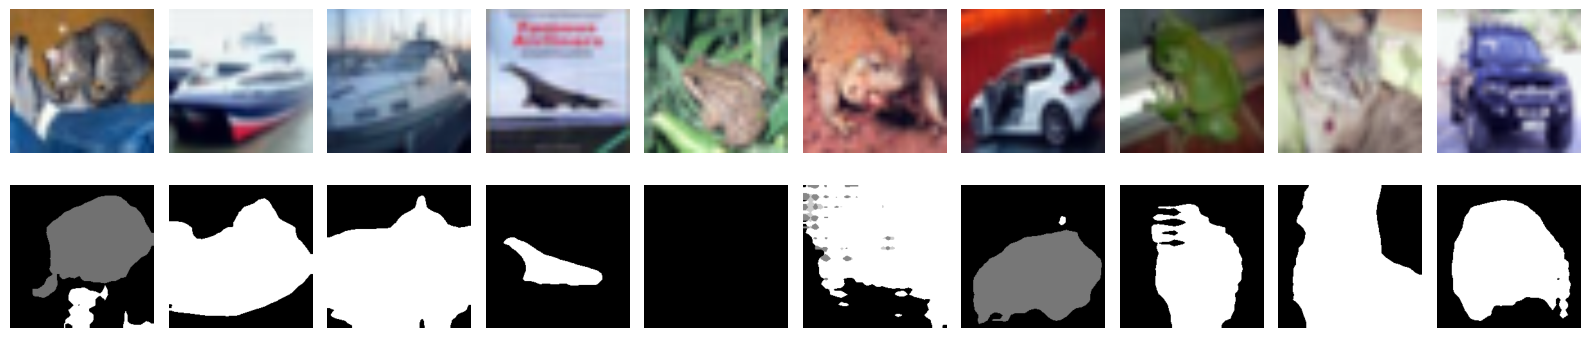

In [ ]:
def plot_segmentation(images, predictions, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(16, 4))

    for i in range(num_images):
        # Original image
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

        # Predicted segmentation mask (grayscale, where white is the segmented region)
        mask = predictions[i].cpu().detach().numpy()
        axes[1, i].imshow(mask[0], cmap='gray')  # Show the first channel of the mask
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Get 10 images from the CIFAR-10 testset and perform segmentation
images, _ = next(iter(testloader))

with torch.no_grad():
    images = images.cuda()
    outputs = fcn(images)  # Get output from the FCN model
    predictions = outputs['out']  # Shape: [batch_size, num_classes, H, W]

    # Convert the output to binary masks (1 if the object is detected, 0 otherwise)
    pred_masks = torch.argmax(predictions, dim=1).unsqueeze(1)  # Get the most likely class for each pixel

# Plot the segmentation results for the first 10 images
plot_segmentation(images, pred_masks)

# Segment the whole testset (10 mins on GPU for 10K images, much faster than SAM)

In [ ]:
# import os
# import shutil

# # Paths
# shapes_dir = "/content/shapes"
# labels_file = "/content/labels.txt"

# # Delete the shapes directory if it exists
# if os.path.exists(shapes_dir):
#     shutil.rmtree(shapes_dir)
#     print(f"Deleted directory: {shapes_dir}")
# else:
#     print(f"Directory not found: {shapes_dir}")

# # Delete the labels file if it exists
# if os.path.exists(labels_file):
#     os.remove(labels_file)
#     print(f"Deleted file: {labels_file}")
# else:
#     print(f"File not found: {labels_file}")

Deleted directory: /content/shapes
Deleted file: /content/labels.txt


<ipython-input-31-92a95d6b3dd0>:29: RuntimeWarning: invalid value encountered in divide
  mask = (mask - mask.min()) / (mask.max() - mask.min())
<ipython-input-31-92a95d6b3dd0>:30: RuntimeWarning: invalid value encountered in cast
  mask_img = Image.fromarray((mask * 255).astype(np.uint8))  # Convert to uint8 for saving


done batch 928 / 313


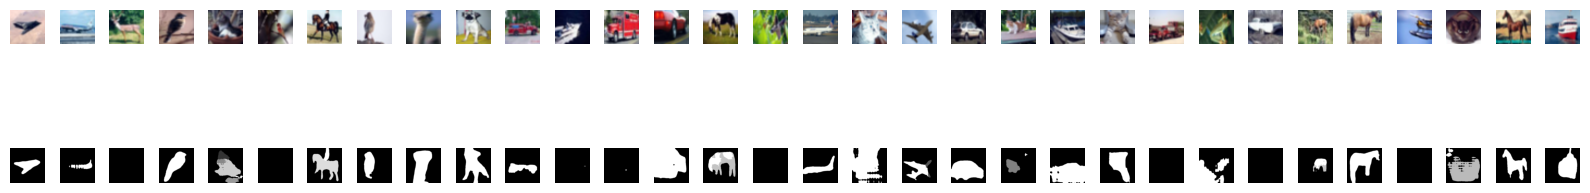

done batch 1888 / 313


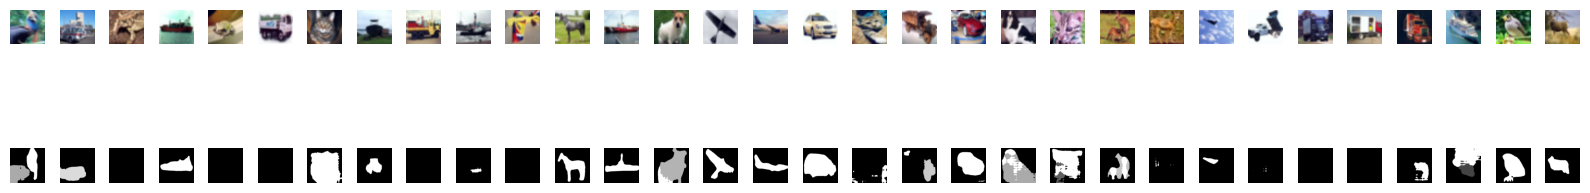

done batch 2848 / 313


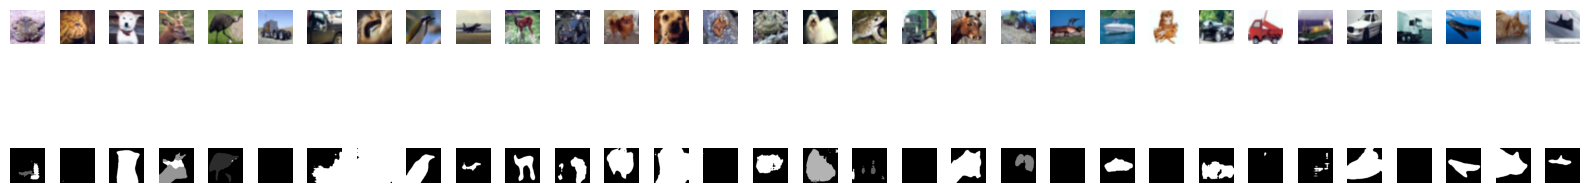

done batch 3808 / 313


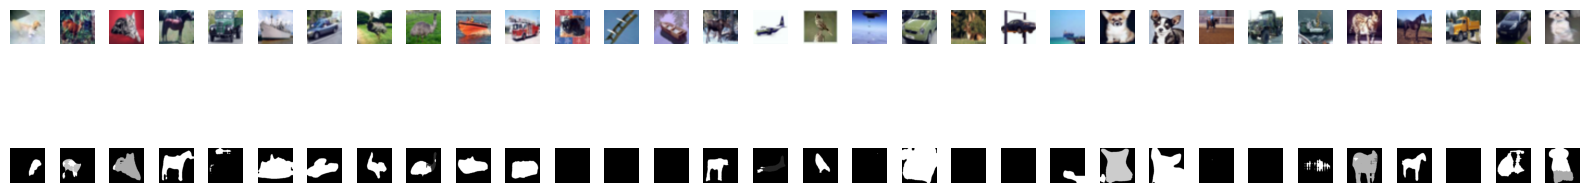

done batch 4768 / 313


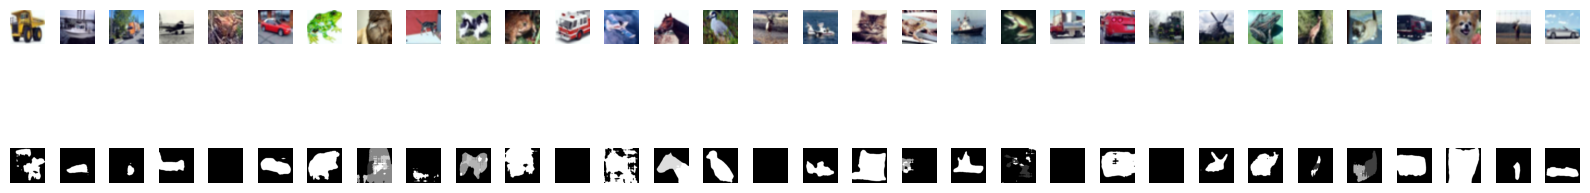

done batch 5728 / 313


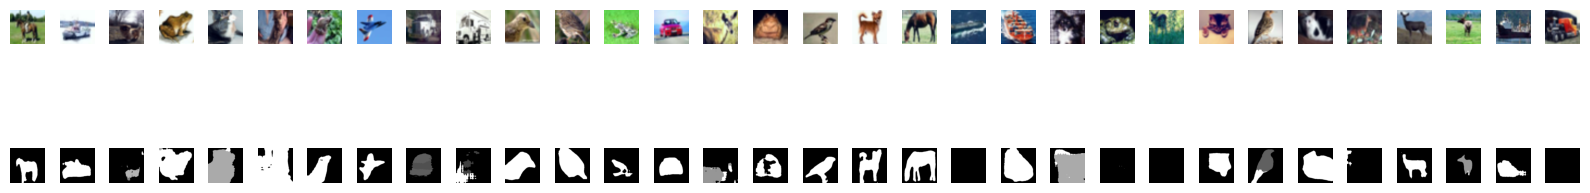

done batch 6688 / 313


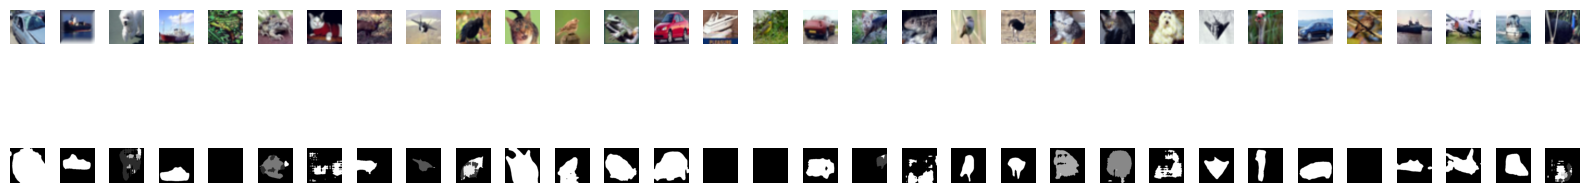

done batch 7648 / 313


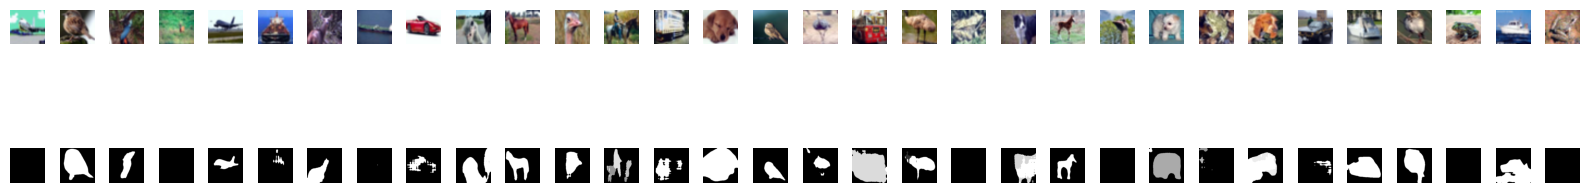

done batch 8608 / 313


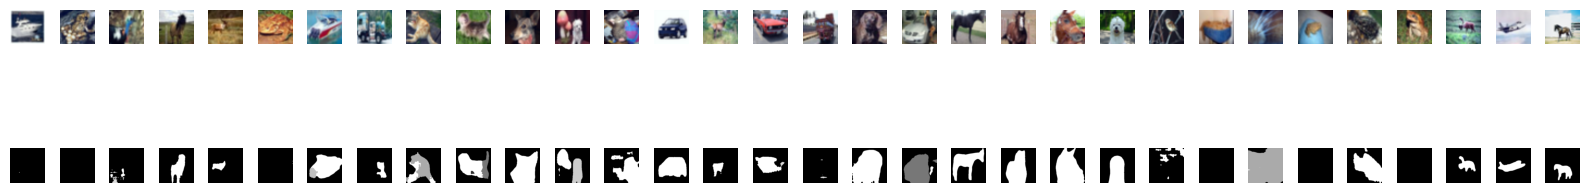

done batch 9568 / 313


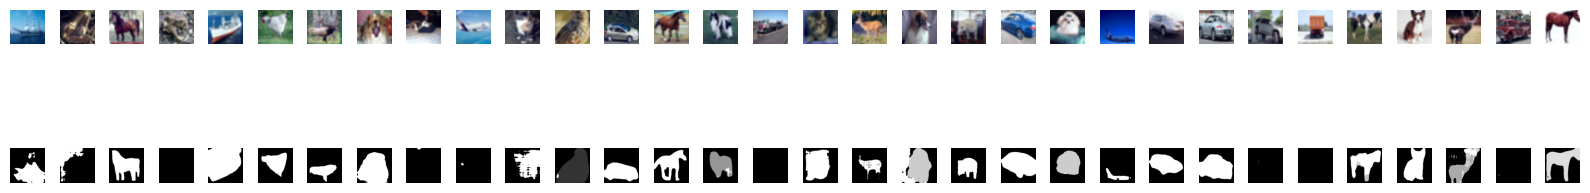

written shape bias dataset


In [ ]:
# Create the output directory and labels file if it doesn't exist
output_dir = '/content/shapes'
os.makedirs(output_dir, exist_ok=True)
labels_file = open('/content/labels.txt', 'w')


fcn.eval()  # Set to evaluation mode
idx = 0
image_counter = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.cuda(), labels.cuda()

        # outputs = fcn(inputs)
        predictions = fcn(inputs)['out']  # Shape: [batch_size, num_classes, H, W]
        pred_masks = torch.argmax(predictions, dim=1).unsqueeze(1)  # Get the most likely class for each pixel
        image_counter +=1

        if image_counter % 30 == 0:
          print(f"done batch {image_counter} / {len(testloader)}")
          plot_segmentation(inputs, pred_masks, num_images=testloader.batch_size)

         # Loop over the batch of images
        for i in range(inputs.size(0)):
            label = labels[i].item()  # Assuming `labels` contains class indices
            img_filename = f"img_{idx + i + 1}.png"
            labels_file.write(f"{img_filename} {label}\n")
            mask = pred_masks[i].cpu().detach().numpy()[0]  # Get the first channel of the mask
            mask = (mask - mask.min()) / (mask.max() - mask.min())
            mask_img = Image.fromarray((mask * 255).astype(np.uint8))  # Convert to uint8 for saving
            mask_img.save(os.path.join(output_dir, img_filename))

        idx += inputs.size(0)  # Increment the index for the next batch



labels_file.close()
print("written shape bias dataset")

In [ ]:
shapes_dir = '/content/shapes'
num_files = len(os.listdir(shapes_dir))
print(f"Number of files in '{shapes_dir}': {num_files}")

# Zip the '/content/shapes' directory
zip_filename = '/content/shapes.zip'

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(shapes_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, shapes_dir)  # Relative path to keep the structure
            zipf.write(file_path, arcname)

print(f"Zipped '{shapes_dir}' to '{zip_filename}'")

Number of files in '/content/shapes': 10000
Zipped '/content/shapes' to '/content/shapes.zip'


In [ ]:
file_path = '/content/shapes.zip'
file_size = os.path.getsize(file_path)
file_size_kb = file_size / 1024  # KB
print(file_size_kb)

8581.173828125


# Memory comparison (KBs) of a png file vs tensor file of 224*224 image

In [ ]:
file_path = '/content/shapes/img_1.png'  #224 by 224 img file
file_size = os.path.getsize(file_path)

# Convert the file size to kilobytes (KB)
file_size_kb = file_size / 1024  # KB
file_size_kb

1.373046875

In [ ]:
file_path = '/content/shapes/img_1.pt'  #224 by 224 tensor
file_size = os.path.getsize(file_path)

# Convert the file size to kilobytes (KB)
file_size_kb = file_size / 1024  # KB
file_size_kb

12545.080078125

# Superpixelation (SLIC algorithm)

In [ ]:
import math
from skimage import io, color
from skimage.transform import resize
import numpy as np

# function which returns an object of class SuperPixel
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])

# To define the initial cluster centers distanced at S
def initial_cluster_center(S,img,img_h,img_w,clusters):
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w,img))
            w += S
        w = S // 2
        h += S
    return clusters

# function to calculate gradient at each pixel
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = img[w + 1, h + 1][0] - img[w, h][0] + img[w + 1, h + 1][1] - img[w, h][1] + img[w + 1, h + 1][2] - img[w, h][2]
    return grad

# function which reassign the cluster center to the pixel having the lowest gradient
def reassign_cluster_center_acc_to_grad(clusters,img,img_w,img_h):
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H,W][0], img[H,W][1],img[H,W][2])
                    c_gradient = new_gradient
'''
function to assign pixels to the nearest cluster using the Euclidean distance involving both color and spatial
proximity.
'''
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

# function to replace the cluster center with the mean of the pixels contained in the cluster
def update_cluster_mean(clusters,img):
    for c in clusters:
        sum_h = sum_w = number = 0
        #print("c.pixels",c.pixels)
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])

# replace the color of each pixel in a cluster by the color of the cluster's center
def avg_color_cluster(img,name,clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # To change the color of cluster center to Black
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    lab2rgb(name, image)

# function for the Simple Linear Iterative Clustering
def slic(S,img,img_h,img_w,clusters,tag,dis,index=0):
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img,img_w,img_h)
    iters = 2   # usually the algortihm converges within 10 iterations
    for i in range(iters):
        # print("i=",i)
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis)
        update_cluster_mean(clusters,img)
        # if i == 9 : # to print the output after 10 iterations
        if i == iters-1:
          name = f'img_{index}.png'
          avg_color_cluster(img,name, clusters)
    return clusters

# function to convert LAB images back to RGB and save it
def lab2rgb(path, lab_arr):
    rgb_arr = color.lab2rgb(lab_arr)
    rgb_arr = (rgb_arr * 255).astype(np.uint8)
    output_dir = '/content/slic'
    path = os.path.join(output_dir, path)
    io.imsave(path, rgb_arr)

# A class to initialize the super pixels, of the form - [h,y,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b


In [ ]:
# read the input RGB image
# rgb = io.imread("/content/bbgate.jpg",plugin='matplotlib')
# print("Random image "rgb.shape)

for inputs, labels in testloader:
    first_image = inputs[0].permute(1, 2, 0).numpy()  # Convert from tensor to numpy array (HWC format)
    rgb = np.clip(first_image, 0, 1)  # Normalize the image values to [0, 1] if needed (CIFAR-10 typically ranges from [0, 1])
    print("CIFAR 10 Input image shape:", rgb.shape)
    break

# input images are resized to (400 x 400) for processing
img = resize(rgb, (330,330),anti_aliasing=True)
print(img.shape)

# convert RGB to LAB
img = color.rgb2lab(img)


img_h = img.shape[0] # Image Height
img_w = img.shape[1] # Image Width

k = 100   # Number of Super pixels
m = 20    # Constant for normalizing the color proximity, range of m = [1,40]
N = img_h * img_w  # Total number of pixels in the image
S = int(math.sqrt(N /k)) # average size of each superpixel

clusters = []
tag = {}

# initialize the distance between pixels and cluster center as infinity
dis = np.full((img_h, img_w), np.inf)

CIFAR 10 Input image shape: (224, 224, 3)
(330, 330, 3)


In [ ]:
cluster = slic(S,img,img_h,img_w,clusters,tag,dis)
# for c in cluster:       # superpixels
#     print("H {} : W {}, l {}, a {}, b {}".format(c.h,c.w,c.l,c.a,c.b))

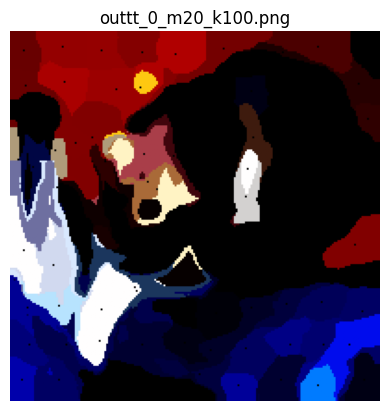

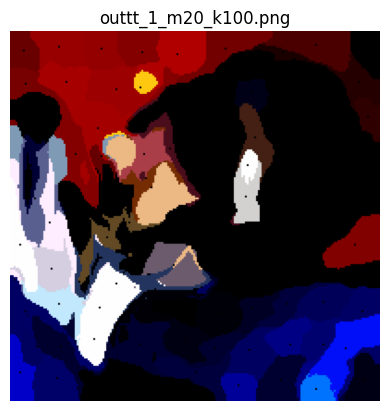

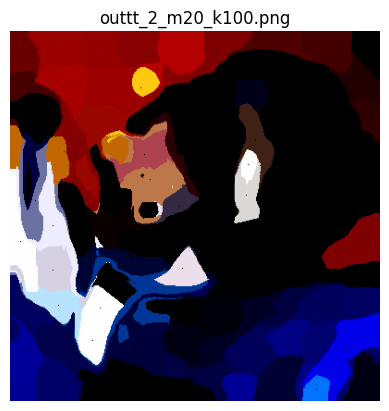

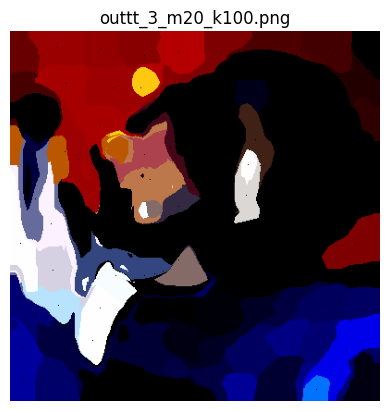

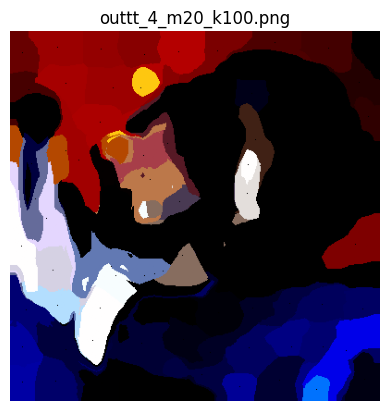

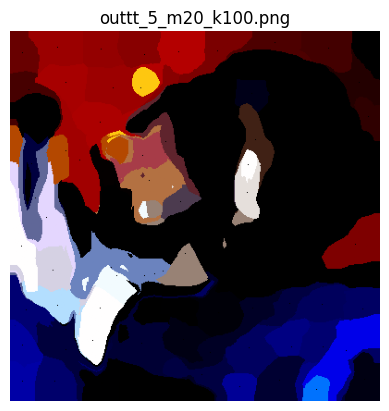

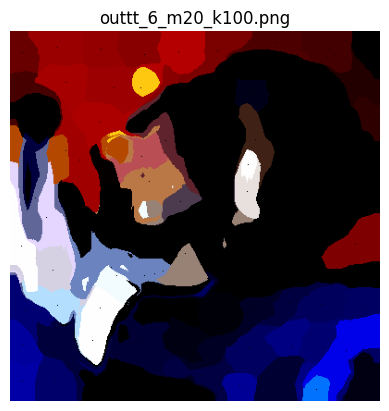

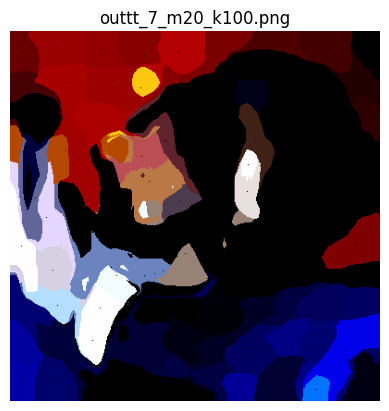

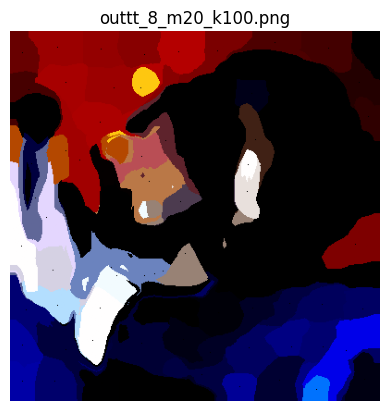

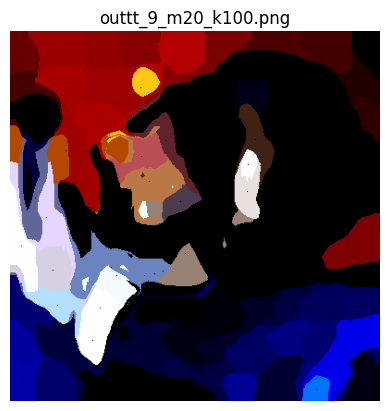

In [ ]:
import os
import matplotlib.pyplot as plt

# Directory path containing the files
directory = '/content/'

# Function to check if a filename matches the required pattern
def is_matching_file(filename):
    # Check if the filename starts with 'out_' and the 5th character is a digit
    # return filename.startswith('out_') and len(filename) > 4 and filename[4].isdigit()
    return filename.startswith('outtt_') and len(filename) > 4 #and filename[4].isdigit()

# Get a list of all matching files
matching_files = [f for f in os.listdir(directory) if is_matching_file(f)]

# Sort files for consistent visualization order (optional)
matching_files.sort()

# Visualize the matching files
for file in matching_files:
    file_path = os.path.join(directory, file)
    try:
        # Load and display the file
        img = plt.imread(file_path)  # Assuming the files are images
        plt.figure()
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')  # Hide axes for better visualization
    except Exception as e:
        print(f"Could not display file {file}: {e}")

plt.show()


In [ ]:
# import shutil

# slic_dir = "/content/slic"
# # labels_file = "/content/labels.txt"

# # Delete the shapes directory if it exists
# if os.path.exists(slic_dir):
#     shutil.rmtree(slic_dir)

In [ ]:
# output_dir = '/content/slic'
# os.makedirs(output_dir, exist_ok=True)

In [ ]:
import zipfile

# Paths
zip_path = '/content/slic.zip'
extract_path = '/content/slic'

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Unzipped '{zip_path}' to '{extract_path}'.")

Unzipped '/content/slic.zip' to '/content/slic'.


In [ ]:
import os
from skimage import color
from skimage.transform import resize
from multiprocessing import Pool, Manager



# Function to process a single image
def process_image(args):
    index, imgggg = args  # Unpack the arguments
    if index in indices:
      return

    imgggg = imgggg.permute(1, 2, 0).numpy()  # Convert from tensor to numpy array (HWC format)
    rgb = np.clip(imgggg, 0, 1)  # Normalize the image values to [0, 1] if needed
    img = resize(rgb, (330, 330), anti_aliasing=True)
    img = color.rgb2lab(img)  # Convert to LAB

    img_h, img_w = img.shape[:2]
    k = 100  # Number of superpixels
    N = img_h * img_w
    S = int(np.sqrt(N / k))  # Average size of each superpixel

    clusters = []
    tag = {}
    dis = np.full((img_h, img_w), np.inf)  # Initialize distance matrix
    slic(S, img, img_h, img_w, clusters, tag, dis, index=index)  # Call SLIC function

    # View every 50th image
    if index % 50 == 0:
        print("Processed image count:", index)

# Main parallel processing logic
if __name__ == "__main__":
    c = 0
    tasks = []  # List to hold tasks for parallel processing

    for inputs, labels in testloader:
        for im in inputs:
            tasks.append((c, im))  # Append index and image to the task list
            c += 1

    # Use multiprocessing to process images in parallel
    num_workers = os.cpu_count()  # Get the number of CPU cores
    with Pool(processes=num_workers) as pool:
        pool.map(process_image, tasks)

    print("All images processed and saved in:", output_dir)


Processed image count: 7250
Processed image count: 6000


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_6941.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 6950
Processed image count: 5700
Processed image count: 6650


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_6651.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 5400
Processed image count: 5100
Processed image count: 6350
Processed image count: 7300
Processed image count: 6050


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_6687.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7000
Processed image count: 5750


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_5437.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 6700
Processed image count: 5450
Processed image count: 5150
Processed image count: 6400


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_5469.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7350
Processed image count: 6100
Processed image count: 7050
Processed image count: 5800
Processed image count: 6750


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_5499.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 5500
Processed image count: 5200
Processed image count: 6450


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_7084.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7400
Processed image count: 6150


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_6777.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7100
Processed image count: 5850


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_5235.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 6800
Processed image count: 5550
Processed image count: 5250
Processed image count: 6500
Processed image count: 7450
Processed image count: 6200


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_6523.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7150
Processed image count: 5900
Processed image count: 6850


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_5599.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 5600
Processed image count: 5300
Processed image count: 6550


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_6239.png is a low contrast image
  io.imsave(path, rgb_arr)
<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_6874.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7500
Processed image count: 6250
Processed image count: 9400
Processed image count: 8150
Processed image count: 9100
Processed image count: 7850


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_7539.png is a low contrast image
  io.imsave(path, rgb_arr)
<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9728.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7550
Processed image count: 8800
Processed image count: 8500
Processed image count: 9750
Processed image count: 9450
Processed image count: 8200


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9765.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 9150
Processed image count: 7900


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9464.png is a low contrast image
  io.imsave(path, rgb_arr)
<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9776.png is a low contrast image
  io.imsave(path, rgb_arr)
<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9473.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7600
Processed image count: 8850
Processed image count: 8550
Processed image count: 9800
Processed image count: 9500
Processed image count: 8250
Processed image count: 9200
Processed image count: 7950
Processed image count: 7650
Processed image count: 8900


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_8910.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 8600


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_7663.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 9850
Processed image count: 9550
Processed image count: 8300


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_8616.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 9250
Processed image count: 8000


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_8315.png is a low contrast image
  io.imsave(path, rgb_arr)
<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_8322.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 7700
Processed image count: 8950


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9584.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 8650
Processed image count: 9900


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9590.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 8350
Processed image count: 9600


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9921.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 9300
Processed image count: 8050
Processed image count: 7750
Processed image count: 9000
Processed image count: 8700
Processed image count: 9950
Processed image count: 9650
Processed image count: 8400
Processed image count: 9350
Processed image count: 8100
Processed image count: 7800
Processed image count: 9050
Processed image count: 8750


<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_8128.png is a low contrast image
  io.imsave(path, rgb_arr)
<ipython-input-4-ba838ff2a1b3>:115: UserWarning: /content/slic/img_9694.png is a low contrast image
  io.imsave(path, rgb_arr)


Processed image count: 8450
Processed image count: 9700


NameError: name 'output_dir' is not defined

In [ ]:
import os
import zipfile

# # Define the folder path and zip file path
folder_path = '/content/slic'
zip_file_path = '/content/slic.zip'

# Calculate the folder size
def get_folder_size(folder):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)
    return total_size

# Zip the folder
def zip_folder(folder, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for dirpath, dirnames, filenames in os.walk(folder):
            for file in filenames:
                file_path = os.path.join(dirpath, file)
                arcname = os.path.relpath(file_path, folder)
                zipf.write(file_path, arcname)

# Get folder size and zip the folder
folder_size = get_folder_size(folder_path)
zip_folder(folder_path, zip_file_path)

folder_size_mb = folder_size / (1024 * 1024)  # Convert to MB
print(folder_size_mb, zip_file_path)

72.2698802947998 /content/slic.zip


In [ ]:
folder_path = '/content/slic'
if os.path.exists(folder_path):
    num_files = sum(os.path.isfile(os.path.join(folder_path, file)) for file in os.listdir(folder_path))
    print(f"Number of files in '{folder_path}': {num_files}")
else:
    print(f"The folder '{folder_path}' does not exist.")\


indices = []

if os.path.exists(folder_path):
    for file in os.listdir(folder_path):
        if file.startswith('img_') and file.endswith('.png'):
            # Extract the index part of the filename
            index = int(file.split('_')[1].split('.')[0])
            indices.append(index)
    indices.sort()  # Sort indices to maintain order
    print(f"Extracted indices: {len(indices)}")
else:
    print(f"The folder '{folder_path}' does not exist.")



Number of files in '/content/slic': 10000
Extracted indices: 10000


In [ ]:
def get_ranges(indices):
    indices.sort()  # Ensure the indices are sorted
    ranges = []
    start = indices[0]

    for i in range(1, len(indices)):
        # If the current number is not consecutive, close the range
        if indices[i] != indices[i - 1] + 1:
            ranges.append([start, indices[i - 1]])
            start = indices[i]  # Start a new range

    # Append the last range
    ranges.append([start, indices[-1]])
    return ranges

# Get ranges and print them
ranges = get_ranges(indices)
print(f"Ranges: {ranges}")

Ranges: [[0, 9999]]


In [ ]:
# output_dir = '/content/slic'
# os.makedirs(output_dir, exist_ok=True)
# c=0
# for  inputs, labels in testloader:
#     for im in inputs:
#       imgggg = im.permute(1, 2, 0).numpy()  # Convert from tensor to numpy array (HWC format)
#       rgb = np.clip(imgggg, 0, 1)  # Normalize the image values to [0, 1] if needed (CIFAR-10 typically ranges from [0, 1])
#       img = resize(rgb, (400,400),anti_aliasing=True)
#       # k = 100
#       img = color.rgb2lab(img)
#       clusters = []
#       tag = {}
#       cluster = slic(S,img,img_h,img_w,clusters,tag,dis,index=c)
#       #view every 50th image
#       if c%50 == 0:
#           print("SLIC count",c)
#       c+=1

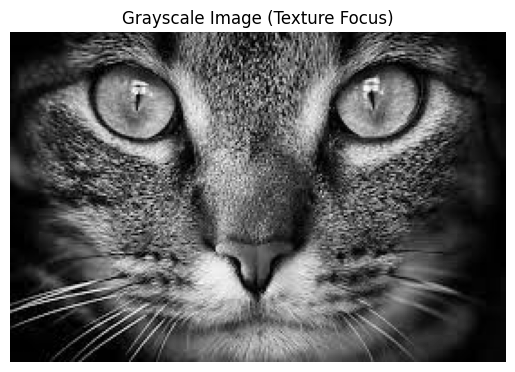

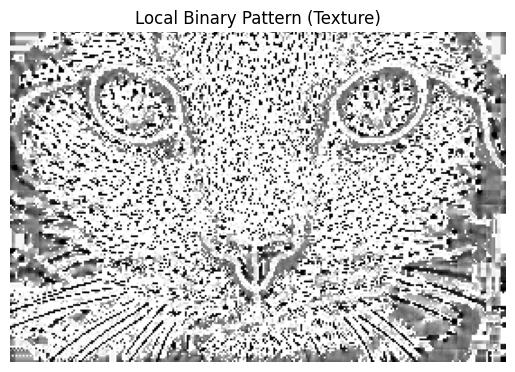

(183, 275)


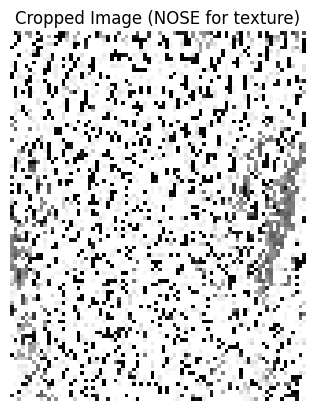

In [ ]:
# from skimage.color import rgb2gray, gray2rgb
# from skimage import io
# import matplotlib.pyplot as plt

# # Load the image
# image = io.imread('/content/cat.jpg')  # Ensure your path is correct

# # Convert to grayscale
# gray_image = rgb2gray(image)

# # Display the grayscale image (texture focus)
# plt.imshow(gray_image, cmap='gray')
# plt.title("Grayscale Image (Texture Focus)")
# plt.axis('off')
# plt.show()

# from skimage.feature import local_binary_pattern

# # Parameters for LBP
# radius = 3  # Neighborhood radius
# n_points = 8 * radius  # Number of points around the circle

# # Compute LBP
# lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')

# # Display LBP
# plt.imshow(lbp, cmap='gray')
# plt.title("Local Binary Pattern (Texture)")
# plt.axis('off')
# plt.show()

# print(lbp.shape)
# top, left = 0, 100  # Starting coordinates
# bottom, right = 100, 180  # Ending coordinates

# cropped_image = lbp[top:bottom, left:right]
# plt.imshow(cropped_image,cmap='gray')
# plt.title("Cropped Image (NOSE for texture)")
# plt.axis('off')
# plt.show()